# 2018/2019 - Task List 1

1. Generate random variable from prefered dystribution using Pyro (pyro.sample)
    
    - animate how distribution of values changes
    - animate histograms of values
    - start with empty list of values, generate new samples, generate histogram
    
    
2. Write a simulator (and exact solution utilizing Bayes theorem) for chances to be ill on a certain disease. We know that it affects from about 1 to 100 out of 50,000 people. There was developed a test to check whether the person has the disease and it is quite accurate: the probability that the test result is positive (suggesting the person has the disease), given that the person does not have the disease, is only 2 percent; the probability that the test result is negative (suggesting the person does not have the disease), given that the person has the disease, is only 1 percent. When a random person gets tested for the disease and the result comes back positive, what is the probability that the person has the disease? Check whole parameter space and visualise results.

    - it must be a simulator!
    - sample from distribution using given probabilities
    - repeate experiment and compare with Bayes equation


## Required imports

In [1]:
%matplotlib inline
import pyro
import torch
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML

## Generating single value from normal distribution with given mean and variance

In [38]:
mean = 0
variance = 10
x = pyro.sample("normal_sampling", pyro.distributions.Normal(mean, variance))
print(x)

tensor(-3.9235)


## Sampling from categorical probabilities with given probabilities

In [39]:
x = pyro.sample("categorical_sampling", pyro.distributions.Categorical(logits = torch.tensor([0.5, 0.5])))
print(x)

tensor(0)


## Animating data

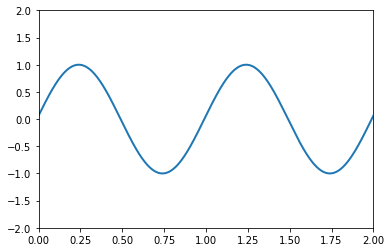

In [40]:
def animate():
    # First set up the figure, the axis, and the plot element we want to animate
    fig, ax = plt.subplots()

    ax.set_xlim(( 0, 2))
    ax.set_ylim((-2, 2))

    line, = ax.plot([], [], lw=2)
    
    # animation function. This is called sequentially
    def sin(i):
        x = np.linspace(0, 2, 1000)
        y = np.sin(2 * np.pi * (x - 0.01 * i))
        line.set_data(x, y)
        return (line,)

    # initialization function: plot the background of each frame
    def init():
        line.set_data([], [])
        return (line,)
    # call the animator. blit=True means only re-draw the parts that have changed.
    anim = animation.FuncAnimation(fig, sin, init_func=init,
                                   frames=100, interval=20, blit=True)
    return HTML(anim.to_jshtml())

animate()

## Drawing histogram

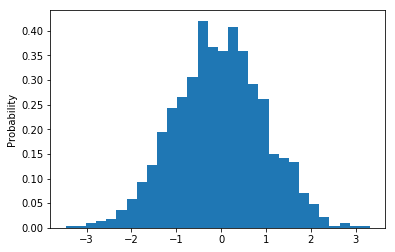

In [41]:
x = np.random.normal(size = 1000)
plt.hist(x, density=True, bins=30)
plt.ylabel('Probability');

## Task 1

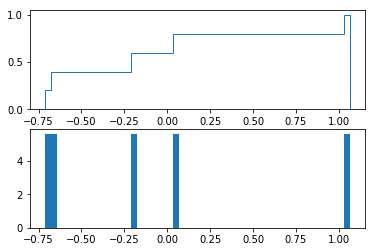

In [15]:
import pyro.distributions as distributions

MEAN = 0
VARIANCE = 1
FRAMES_COUNT = 5
DISTRIBUTION_TYPE = "normal_sampling"

def animation_task_1(frames_count, data_list):
    fig, (ax1, ax2) = plt.subplots(2)

    def update_functions(num, samples):
        def prepare_histograms(values_to_present):
            ax1.cla()
            ax2.cla()
            ax1.hist(values_to_present, density = True, histtype = 'step', cumulative = True, bins = 50)
            ax2.hist(values_to_present, density = True, bins = 50)
            
        prepare_histograms(samples[0: num + 1])

    anim = animation.FuncAnimation(fig, update_functions, frames_count, fargs = (data_list, ))

    return HTML(anim.to_jshtml())

sample_generator = lambda: pyro.sample(DISTRIBUTION_TYPE, distributions.Normal(MEAN, VARIANCE))
sample_list = list((sample_generator() for n in range(FRAMES_COUNT)))

animation_task_1(FRAMES_COUNT, sample_list)

## Task 2

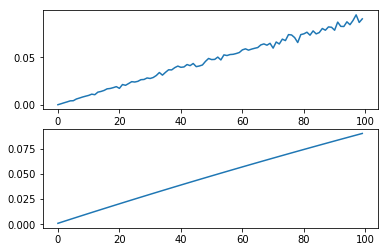

In [172]:
import pyro.distributions as distributions
from enum import Enum


class Person(Enum):
    HEALTH = 1
    SICK = 0


class TestResult(Enum):
    HEALTH = 1
    SICK = 0


MAX_SICK_COUNT = 100
POPULATION_COUNT = 50000

PROBABILITY_NEGATIVE_SICK = 0.01  # test negative, in fact sick
PROBABILITY_POSITIVE_SICK = 1 - PROBABILITY_NEGATIVE_SICK
PROBABILITY_POSITIVE_HEALTHY = 0.02  # test positive, in fact health
PROBABILITY_NEGATIVE_HEALTHY = 1 - PROBABILITY_POSITIVE_HEALTHY

TEST_FOR_SICK = "test_for_sick"
TEST_FOR_HEALTH = "test_for_health"


def simulation_for_sick_count(sick_count):
    positive_counter = 0
    positive_sick_counter = 0

    def get_person_state(person_index):
        return Person.SICK if (person_index + 1) < sick_count else Person.HEALTH

    def get_test_result_for_person(person_state):

        def get_test_result_for_sick():
            categorical_for_sick = distributions.Categorical(
                probs=torch.tensor([PROBABILITY_POSITIVE_SICK, PROBABILITY_NEGATIVE_SICK]))
            return pyro.sample(TEST_FOR_SICK, categorical_for_sick)

        def get_test_result_for_health():
            categorical_for_health = distributions.Categorical(
                probs=torch.tensor([PROBABILITY_POSITIVE_HEALTHY, PROBABILITY_NEGATIVE_HEALTHY]))
            return pyro.sample(TEST_FOR_HEALTH, categorical_for_health)

        category = get_test_result_for_sick() if person_state == Person.SICK else get_test_result_for_health()
        return TestResult.SICK if category == 0 else TestResult.HEALTH

    for i in range(POPULATION_COUNT):
        person_state = get_person_state(i)
        test_result = get_test_result_for_person(person_state)

        if test_result == TestResult.SICK:
            positive_counter += 1
        if person_state == Person.SICK and test_result == TestResult.SICK:
            positive_sick_counter += 1

    return positive_sick_counter / positive_counter


def count_from_bayes(sick_count):
    probability_of_sick_person = sick_count / POPULATION_COUNT
    probability_of_health_person = 1 - probability_of_sick_person
    probability_of_positive = \
        probability_of_sick_person * PROBABILITY_POSITIVE_SICK + probability_of_health_person * PROBABILITY_POSITIVE_HEALTHY
    probability_of_sick_positive = (PROBABILITY_POSITIVE_SICK * probability_of_sick_person) / probability_of_positive
    return probability_of_sick_positive


def animate():
    frames = MAX_SICK_COUNT
    simulation_results = []
    bayes_results = []

    for i in range(frames):
        simulation_results += [simulation_for_sick_count(i + 1)]
        bayes_results += [count_from_bayes(i + 1)]
        
    fig, (ax1, ax2) = plt.subplots(2)

    def frame_function(num, simulation_data, bayes_data):
        ax1.cla()
        ax2.cla()
        ax1.plot(simulation_data[0:num + 1])
        ax2.plot(bayes_data[0:num + 1])

    anim = animation.FuncAnimation(fig, frame_function, frames, fargs=(simulation_results, bayes_results))

    return HTML(anim.to_jshtml())


animate()
